In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.4 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import seaborn
import numpy as np
import pandas as pd
import random
import tqdm
from tqdm import notebook
import albumentations as A

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as functional
import torchvision


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [ ]:
images_dir = '/content/drive/MyDrive/Colab Notebooks/u net/main'
train_images_dir = os.path.join(images_dir, 'train')
val_images_dir = os.path.join(images_dir, 'val')
working_dir = '/content/drive/MyDrive/Colab Notebooks/u net'
weights_path = os.path.join(working_dir, '/content/drive/MyDrive/Colab Notebooks/u net/unet.pth')
logs_path = os.path.join(working_dir, 'logs')

In [ ]:
data_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks/u net/main")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


In [ ]:
class Generator(object):
    def __init__(self, images_dir, batch_size, is_augmentation, shuffle = True, rescale = 1.00, target_size = (256, 256)):
        super(Generator, self).__init__()
        self.images_dir = images_dir
        self.batch_size = batch_size
        self.rescale = rescale
        self.shuffle = shuffle
        self.is_augmentation = is_augmentation
        self.target_size = target_size
        self.filenames = [os.path.join(self.images_dir, filename) for filename in os.listdir(self.images_dir)]
        self.current_step = 0
        self.count_images = len(self.filenames)
        self.available_steps = int(self.count_images // self.batch_size)

        self.transforms = A.Compose([
            A.Rotate(25),
            A.OneOf([
                A.RGBShift(), A.HueSaturationValue()
            ]),
            A.OneOf([
                A.CLAHE(), A.RandomBrightnessContrast(), A.RandomGamma()
            ]),
        ])

    def augmentate(self, batch):
        batch = batch.astype(np.uint8)
        batch = [self.transforms(image = image, mask = mask) for (image, mask) in batch]
        batch = np.array([(transformed['image'], transformed['mask']) for transformed in batch], dtype = np.float32)
        return batch

    def generate_batch(self):
        start = self.current_step * self.batch_size
        stop = (self.current_step + 1) * self.batch_size
        filenames_batch = self.filenames[start:stop]


        images_batch = [cv2.imread(filename) for filename in filenames_batch]


        images_batch = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images_batch])


        images_batch = np.array([(image[:, :256,], image[:, 256:]) for image in images_batch])


        images_batch = np.array([(cv2.resize(image, self.target_size), cv2.resize(mask, self.target_size)) for (image, mask) in images_batch], dtype = np.float32)


        if self.is_augmentation:
            images_batch = self.augmentate(images_batch)


        images_batch = np.array([(np.moveaxis(image, -1, 0), np.moveaxis(mask, -1, 0)) for (image, mask) in images_batch])


        images_batch /= self.rescale
        #resampling
        images_batch = np.moveaxis(images_batch, 1, 0)

        return torch.Tensor(images_batch)

    def __next__(self):
        if self.current_step > self.available_steps:
            self.current_step = 0
        images, masks = self.generate_batch()
        self.current_step += 1
        return images, masks

    def __len__(self):
        return self.available_steps

In [ ]:
def show_examples(num_cols):
    stacks = []
    dataloader = Generator(images_dir = train_images_dir, batch_size = 8, is_augmentation = True, rescale = 255.0)
    for iteration in range(num_cols):
        images, masks = next(dataloader)
        images, masks = images.numpy(), masks.numpy()
        images, masks = np.concatenate(np.moveaxis(images, 1, -1)), np.concatenate(np.moveaxis(masks, 1, -1))

        stack = np.hstack([images, masks])
        stacks.append(stack)
    result = np.hstack(stacks)
    plt.figure(figsize = (30, 30))
    plt.axis('off')
    plt.imshow(result)
show_examples(2)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange


def pair(t):
    return t if isinstance(t, tuple) else (t, t)



class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8,dim_head=64, dropout=0.):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, dropout=dropout)

    def forward(self, x):
        x = x.permute(1, 0, 2)
        attn_output, _ = self.multihead_attn(x, x, x)
        # Permute back to the original shape
        attn_output = attn_output.permute(1, 0, 2)
        return attn_output

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, dim, depth, heads, mlp_dim, pool = 'cls', channels = 512, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()


    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        x = self.transformer(x)
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        x = self.to_latent(x)
        return x

In [ ]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):


    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
      def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1)
        self.conv = ResidualBlock(in_channels, out_channels)
      def forward(self, x1, x2):
        x_upsampled = self.up(x1)
        x_concat = torch.cat((x_upsampled, x2), dim=1)

        x_upsampled_refined = self.conv(x_concat)
        return x_upsampled_refined






class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ResidualBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes


        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)

        self.down4 = Down(512, 1024)



        self.vit = ViT(image_size=32, patch_size=8, dim=2048, depth=3, heads=16, mlp_dim=1024, channels=1024)
        self.vit_conv = nn.Conv2d(8, 1024, kernel_size=1, padding=0)
        # self.vit_linear = nn.Linear(64, 1024)

        self.up1= Up(1024,512)
        self.up4 = Up(512, 256 )
        self.up3 = Up(256, 128 )
        self.up2 = Up(128, 64)
        # self.up1 = Up(64, 64)
        self.out_conv = nn.Conv2d(64, n_classes, kernel_size=1)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)




        x6 = self.vit(x5)

        x6 = torch.reshape(x6, (-1, 8, 16, 16))

        x7 = self.vit_conv(x6)


        x = self.up1(x7, x4)
        x = self.up4(x, x3)
        x = self.up3(x, x2)
        x = self.up2(x, x1)
        logits = self.out_conv(x)
        return logits

In [ ]:
unet = UNet(n_channels=3, n_classes=3)

In [ ]:
unet

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ResidualBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

In [ ]:
def dice_coefficient(ground_truth, predicted):
    intersection = torch.sum(ground_truth * predicted)
    union = torch.sum(ground_truth) + torch.sum(predicted)

    # Calculate the Dice coefficient
    dice = (2.0 * intersection) / (union + 1e-8)

    return dice

In [ ]:
torch.cuda.empty_cache()


In [ ]:
from torch.optim.lr_scheduler import StepLR

In [ ]:
optimizer = torch.optim.Adam(params=unet.parameters(),
                             lr=1e-5,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=0,
                             amsgrad=False)


scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

criterion = torch.nn.BCEWithLogitsLoss()

history = dict(train_loss=[],
               train_dice_coeff=[],
               test_loss=[],
               test_dice_coeff=[])

def dice_coeff(pred, target):
    pred = (pred > 0).float()
    return 2. * (pred * target).sum() / (pred + target).sum()
def training(model, epochs, batch_size):

    train_generator = Generator(images_dir=train_images_dir, batch_size=batch_size, is_augmentation=True, rescale=255.0)
    test_generator = Generator(images_dir=val_images_dir, batch_size=batch_size, is_augmentation=False, rescale=255.0)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    main_pbar = tqdm.notebook.tqdm(range(epochs))
    main_pbar.set_description('common progress ')

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_dice_coeff = 0.0
        epoch_test_loss = 0.0
        epoch_test_dice_coeff = 0.0


        for step in range(len(train_generator)):

            train_images, train_masks = next(train_generator)
            train_images, train_masks = train_images.to(device), train_masks.to(device)


            optimizer.zero_grad()


            train_predictions = model(train_images)
            train_loss = criterion(train_predictions, train_masks)
            train_loss.backward()


            train_dice_coeff = dice_coeff(pred=train_predictions, target=train_masks)


            epoch_train_loss += train_loss.item()
            epoch_train_dice_coeff += train_dice_coeff.item()

            optimizer.step()


        epoch_train_loss /= len(train_generator)
        epoch_train_dice_coeff /= len(train_generator)


        with torch.no_grad():
            for step in range(len(test_generator)):

                test_images, test_masks = next(test_generator)
                test_images, test_masks = test_images.to(device), test_masks.to(device)

                test_predictions = model(test_images)

                test_loss = criterion(test_predictions, test_masks)

                test_dice_coeff = dice_coeff(pred=test_predictions, target=test_masks)


                epoch_test_loss += test_loss.item()
                epoch_test_dice_coeff += test_dice_coeff.item()


        epoch_test_loss /= len(test_generator)
        epoch_test_dice_coeff /= len(test_generator)


        print(f'Epoch [{epoch + 1}/{epochs}] - '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Train Dice Coeff: {epoch_train_dice_coeff:.4f}, '
              f'Test Loss: {epoch_test_loss:.4f}, '
              f'Test Dice Coeff: {epoch_test_dice_coeff:.4f}')


        history['train_loss'].append(epoch_train_loss)
        history['train_dice_coeff'].append(epoch_train_dice_coeff)
        history['test_loss'].append(epoch_test_loss)
        history['test_dice_coeff'].append(epoch_test_dice_coeff)

        scheduler.step()
        torch.save(unet.state_dict(), weights_path)



training(model=unet, epochs=60, batch_size=16)




  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/60] - Train Loss: 0.5777, Train Dice Coeff: 0.4563, Test Loss: 0.5685, Test Dice Coeff: 0.4566
Epoch [2/60] - Train Loss: 0.5741, Train Dice Coeff: 0.4582, Test Loss: 0.5663, Test Dice Coeff: 0.4595
Epoch [3/60] - Train Loss: 0.5719, Train Dice Coeff: 0.4624, Test Loss: 0.5649, Test Dice Coeff: 0.4547
Epoch [4/60] - Train Loss: 0.5701, Train Dice Coeff: 0.4625, Test Loss: 0.5640, Test Dice Coeff: 0.4585
Epoch [5/60] - Train Loss: 0.5685, Train Dice Coeff: 0.4616, Test Loss: 0.5628, Test Dice Coeff: 0.4562
Epoch [6/60] - Train Loss: 0.5668, Train Dice Coeff: 0.4627, Test Loss: 0.5622, Test Dice Coeff: 0.4496
Epoch [7/60] - Train Loss: 0.5651, Train Dice Coeff: 0.4639, Test Loss: 0.5621, Test Dice Coeff: 0.4648
Epoch [8/60] - Train Loss: 0.5638, Train Dice Coeff: 0.4625, Test Loss: 0.5614, Test Dice Coeff: 0.4463
Epoch [9/60] - Train Loss: 0.5629, Train Dice Coeff: 0.4624, Test Loss: 0.5608, Test Dice Coeff: 0.4547
Epoch [10/60] - Train Loss: 0.5620, Train Dice Coeff: 0.4643, Te

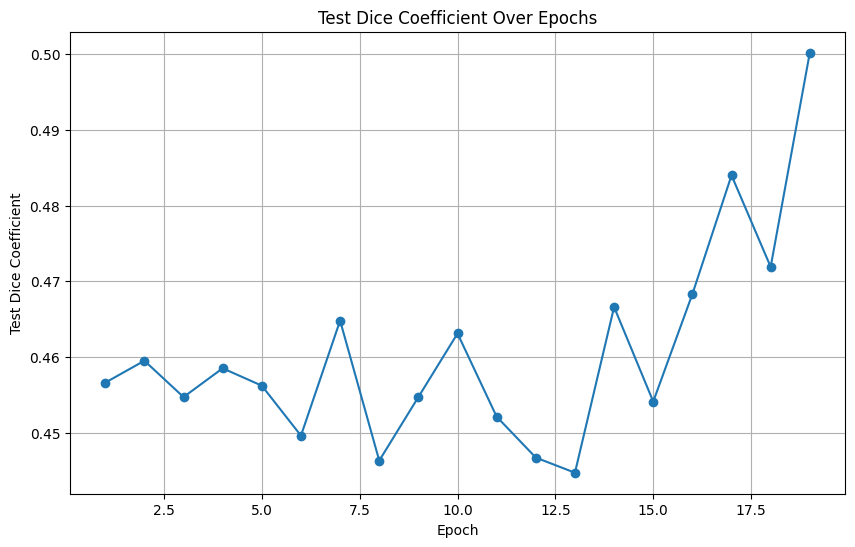

In [ ]:
import matplotlib.pyplot as plt


test_dice_coeff = [0.4566, 0.4595, 0.4547, 0.4585, 0.4562, 0.4496, 0.4648, 0.4463, 0.4547, 0.4631,
                   0.4521, 0.4467, 0.4447, 0.4666, 0.4541, 0.4683, 0.4840, 0.4719, 0.5002]


epochs = list(range(1, len(test_dice_coeff) + 1))


plt.figure(figsize=(10, 6))
plt.plot(epochs, test_dice_coeff, marker='o', linestyle='-')
plt.title('Test Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Dice Coefficient')
plt.grid(True)


plt.show()


ffgfffdbgffffghgff

In [ ]:
training(model=unet, epochs=40, batch_size=16)

In [ ]:
model = UNet(n_channels=3, n_classes=3)
model.load_state_dict(torch.load(weights_path))
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ResidualBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_

In [ ]:
def show_final_results(a,b):
    generator = Generator(images_dir = val_images_dir,
                           batch_size = 8,
                           is_augmentation = True,
                           rescale = 255.0)
    result = []
    for iteration in range(a,b):
        images, masks = next(generator)
        prediction = torch.sigmoid(model(images))
        prediction = prediction.cpu().detach().numpy()
        prediction = np.moveaxis(prediction, 1, -1)
        masks = np.moveaxis(masks.numpy(), 1, -1)
        images = np.moveaxis(images.numpy(), 1, -1)
        prediction = np.concatenate(prediction)
        images = np.concatenate(images)
        masks = np.concatenate(masks)
        outputs = np.hstack([images, masks, prediction])
        result.append(outputs)
    result = np.hstack(result)
    plt.figure(figsize = (30, 30))
    plt.axis('off')
    plt.imshow(result)



DEMO

In [ ]:
show_final_results(1,2)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
show_final_results(2,3)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
show_final_results(4,5)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
show_final_results(6,7)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
show_final_results(10,11)

Output hidden; open in https://colab.research.google.com to view.